In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
%matplotlib inline

Load a mean pulse profile for B1957+20

(-0.1, 0.8)

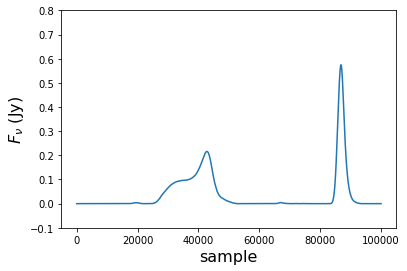

In [2]:
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
meanprof_Jy[meanprof_Jy < 0] = 0
#mean_value = (np.mean(mean_profile) / np.median(mean_profile) - 1) * 12.

#print("Mean pulse flux = %s Jy" % (mean_value))

n = 100000

x = np.arange(1000)
profile = inter.interp1d(x, meanprof_Jy, kind='linear')
xnew = np.arange(0,x.size-1,(x.size-1.)/n)
meanprof_inter = profile(xnew)

plt.plot(meanprof_inter)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
#plt.xlim(0,1.6e-2)
plt.ylim(-.1, 0.8)

Isolatethe main pulse, sqrt it, and center

(-0.1, 0.8)

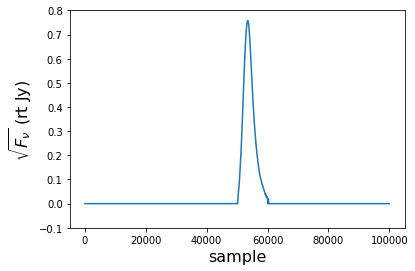

In [12]:
pulse = []

for i in np.arange(meanprof_inter.size):
    if (float(i) < n*830./1000. or float(i) > n*940./1000.):
        pulse.append(0)
    else:
        pulse.append(meanprof_inter[i])

pulse = np.sqrt(pulse)
pulse = np.roll(pulse, -n/3)

plt.plot(pulse)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$\sqrt{F_{\nu}}$ (rt Jy)', fontsize=16)
#plt.xlim(0,1.6e-2)
plt.ylim(-.1, 0.8)

Invent some sinusoidal wave at frequency of observed band

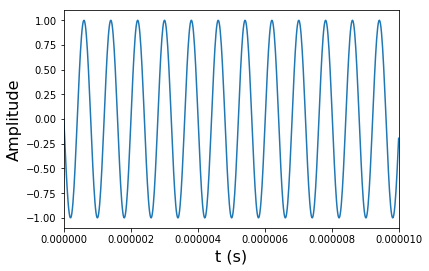

In [30]:
angular_freq = 2*np.pi*311.25*1e6 # Hz
t = np.linspace(0., 1.6, n)*1e-3 # s
phase = np.sin(angular_freq*t)

plt.plot(t, phase)
plt.xlim(0.0, 1e-5)
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'Amplitude', fontsize=16)

Compute an electric field

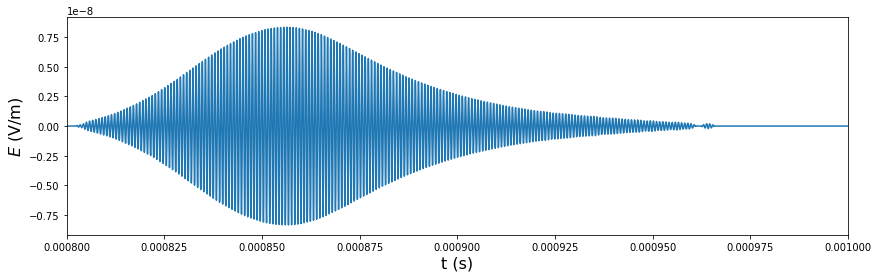

In [28]:
a = 109797 # rt(kg)*m/s^2/A sqrt(2*16MHz/(c*n*epsilon_0)), conversion factor between sqrt(Jansky) and E field strength assuming n=1
b = 1e-13 # rt(kg)/s, a*b = 1.1e-8 N/C

E_field = a*b*pulse*phase

plt.figure(figsize=(14,4))
plt.plot(t, E_field)
plt.xlim(0.8e-3,1e-3)
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)